# LSTM to predict future stock prices

*Code developep for learning the process viewed in this blog and repository:*
* https://medium.com/visionary-hub/using-lstms-to-predict-future-stock-prices-61f4458fc860

* https://github.com/fazalmittu/StockPricePredictor/blob/main/StockPricePredictorProject.ipynb

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
# For represent the data
import matplotlib.pyplot as plt
# For scale the data before introduce in neural network
from sklearn.preprocessing import MinMaxScaler
# For create the model with sequential (model.add())
from tensorflow.keras.models import Sequential
# For create the architecture of the neural network
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [7]:
# Checking GPU 

physical_devices = tf.config.list_physical_devices('GPU')
print(f"Resultado physical devices: {physical_devices}")
print("Num GPUs: ", len(physical_devices))
print("GPU disponible en: ", tf.test.is_gpu_available)

Resultado physical devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs:  1
GPU disponible en:  <function is_gpu_available at 0x000002286AF6D510>


The practical application of this project is to assist stock traders in their buying decisions by using historical data of stock pricing to identify trends and predict future prices. This product was built to provide assurance when making financial decisions. We use data from Apple.

# Reading data

In [38]:
df = pd.read_csv(r"data/AAPL.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-02,70.570000,75.360001,69.430000,74.702499,73.581810,341397200
1,2020-03-03,75.917503,76.000000,71.449997,72.330002,71.244896,319475600
2,2020-03-04,74.110001,75.849998,73.282501,75.684998,74.549568,219178400
3,2020-03-05,73.879997,74.887497,72.852501,73.230003,72.131393,187572800
4,2020-03-06,70.500000,72.705002,70.307503,72.257500,71.173485,226176800


The information is format day by day, sequential, that's good but is not the index, we will fix that. Our target is the column 'Close', because is the price os close price, that we want to know because the model would assist the traders if they should buy or not with that reference.

In [39]:
# Convert to datatime 
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
print(f"Length for the data: {len(df)}")
df.head(5)

Length for the data: 252


,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2020-03-02,2020-03-02,70.570000,75.360001,69.430000,74.702499,73.581810,341397200
2020-03-03,2020-03-03,75.917503,76.000000,71.449997,72.330002,71.244896,319475600
2020-03-04,2020-03-04,74.110001,75.849998,73.282501,75.684998,74.549568,219178400
2020-03-05,2020-03-05,73.879997,74.887497,72.852501,73.230003,72.131393,187572800
2020-03-06,2020-03-06,70.500000,72.705002,70.307503,72.257500,71.173485,226176800


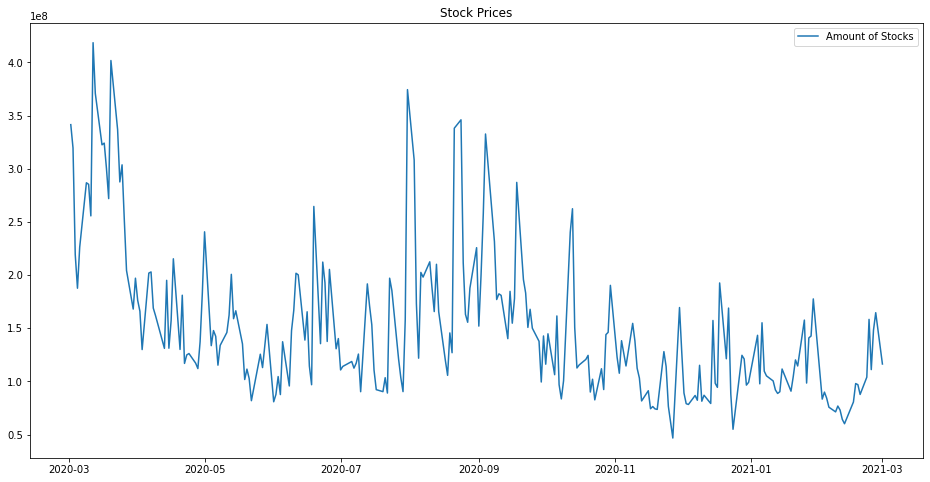

In [40]:
# Represent data
plt.figure(figsize=(16,8))
plt.title("Stock Prices")
plt.plot(df['Volume'], label='Amount of Stocks')
plt.legend(loc='best')
plt.show()

# Data processing

In [41]:
# Create an empty dataframe that will be filled by our data filtered by sorted 'Date' and 'Close' price
dataset = df.sort_index(ascending=True, axis=0)
dataset2 = pd.DataFrame(index=range(0,len(dataset)),columns=['Date', 'Close'])
print(f"Length for the dataset2: {len(dataset2)}")
dataset2.head(5)

Length for the dataset2: 252


,Date,Close
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [42]:
# Process for fill all our data in the new dataframe
for i in range(0,len(dataset)):
    dataset2['Date'][i] = dataset['Date'][i]
    dataset2['Close'][i] = dataset['Close'][i]

# Establish date like index for dataframe
dataset2.index = dataset2.Date
dataset2.drop('Date', axis=1, inplace = True)
print(f"Length for the dataset2: {len(dataset2)}")
dataset2.head(5)

Length for the dataset2: 252


,Close
Date,
2020-03-02,74.702499
2020-03-03,72.330002
2020-03-04,75.684998
2020-03-05,73.230003
2020-03-06,72.2575


In [47]:
# Create Dataset for train and validation
data_df = dataset2.values 
print(f"Length for the dataset3: {len(dataset3)}")

# --- This steps dont do nothing-------

# Train since 0 to position 177. Why? -> Beacause len(data_df) = 252, 252*0.7 = 177
train = data_df[0:177, :]

# Validation lenght the rest of the data since position 177 to the end
validation = data_df[177:, :]

# Shape for the diferents datasets
print(f"Shape for the dataset of train: {train.shape}")
print(f"Shape for the dataset of validation: {validation.shape}")

Length for the dataset3: 252
Shape for the dataset of train: (177, 1)
Shape for the dataset of validation: (75, 1)


## Data Scaling

In [49]:
# We must scale the data because the neural network works with 0 and 1 values

scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data_df)
print(scaled_data[0:5])

[[0.2137422 ]
 [0.18649326]
 [0.22502654]
 [0.19683008]
 [0.18566055]]


In [63]:
# Create secuence of data xtrain, ytrain

# empty list
x_train, y_train = [], []

# Why in this step there are a 60 value?
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60: i, 0])
    y_train.append(scaled_data[i, 0])

# Convert x_train and y_train in array objects
x_train, y_train = np.array(x_train), np.array(y_train)
print(f"Shape for the dataset of train: x_train = {x_train.shape} y_train = {y_train.shape}")

# Why this step??
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(f"Shape for the dataset of train: x_train = {x_train.shape} y_train = {y_train.shape}")

Shape for the dataset of train: x_train = (117, 60) y_train = (117,)
Shape for the dataset of train: x_train = (117, 60, 1) y_train = (117,)


# Model Architecture

In [105]:
model = Sequential()
# Why in this case, input shape is 60,1?? - In the other model of power consumption was the same but diferent value, last_n
model.add(LSTM(units=1000, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=1000))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 1000)          4008000   
                                                                 
 lstm_3 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 12,013,001
Trainable params: 12,013,001
Non-trainable params: 0
_________________________________________________________________


# Training Process

In [106]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1)

117/117 [==============================] - 6s 31ms/step - loss: 0.0292


In [80]:
def ResultsViz(history_model):
    x_range = len(history_model.history['loss'])

    plt.figure(figsize=(15, 5))
    epoch_list = list(range(1,x_range+1))

    plt.plot(epoch_list, history_model.history['loss'], label='Train Loss')
    plt.yticks(fontsize=15)
    plt.xticks(np.arange(0, x_range+1, 2), fontsize=15)
    plt.ylabel('Loss Value')
    plt.xlabel('Epoch')
    plt.title('Training and Validation Results', fontsize=25)
    plt.legend(loc="best", fontsize=12)
    plt.show()

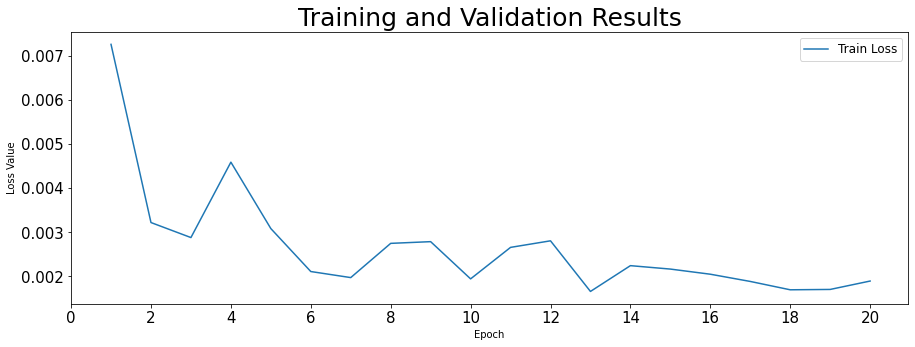

In [81]:
ResultsViz(history)

# Evaluation

In [107]:
# Create sequence of test data for make the predict 

# empty vectors
x_test = []
# y_test = y_pred will be our prediction

# Why in this step there are a 60 value?
for i in range(60, len(test)):
    x_test.append(scaled_data[i-60: i, 0])

# Convert x_train and y_train in array objects
x_test = np.array(x_test)
print(f"Shape for the dataset of test: x_test = {x_test.shape}")

# Why this step??
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
print(f"Shape for the dataset of test: x_test = {x_test.shape}")

Shape for the dataset of test: x_test = (57, 60)
Shape for the dataset of test: x_test = (57, 60, 1)


In [108]:
# Make the prediction for this data

closing_price = model.predict(x_test)
closing_price = scaler.inverse_transform(closing_price)
print(x_test.shape)

2/2 [==============================] - 1s 121ms/step
(57, 60, 1)


In [109]:
len(closing_price)

57

In [110]:
len(valid)

57

In [111]:
len(data_df)

252

In [112]:
len(data_df) - len(closing_price)

195

C:\Users\jerreyes_bec\AppData\Local\Temp\ipykernel_5520\2623938803.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


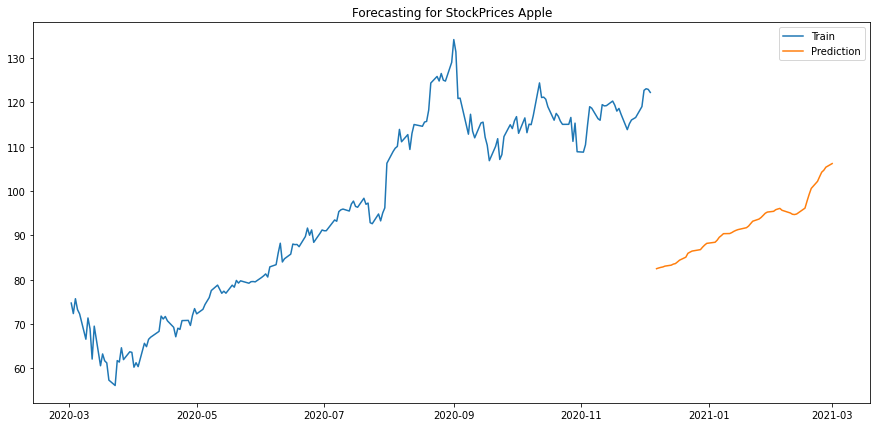

In [114]:
train = dataset2[:195]
valid = dataset2[195:]


valid['Predictions'] = closing_price
plt.figure(figsize=(15,7))
plt.plot(train['Close'], label = 'Train')
plt.plot(valid['Predictions'], label = 'Prediction')
plt.title("Forecasting for StockPrices Apple")
plt.legend(loc='best')
plt.show()

Why the prediction is not like the blog's example? This is weird, for sure we make a mistake but which one? We try to follow all the instruccions, we need learn more about this process, specificly in data processing and representing the prediction and the most import generating the sequence which one enter in the model.